# Visualisation des salaires de la *Tech* en France

Dans ce notebook, on visualise les salaires collectés sur https://salaires.dev/. On commence par un nettoyage assez sommaire des données, puis deux visualisations qui permettent de comparer les salaires de Paris, en remote, et le reste de la France.

## Chargement des paquets et récupération des données

In [1]:
library(dplyr)
library(ggplot2)
library(stringr)
library(ggrepel)
library(repr)
library(jsonlite)
library(ggdist)
library(tidyverse)
library(patchwork)
library(geomtextpath)

options(repr.plot.width=18, repr.plot.height=14)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7     ✔ purrr   0.3.4
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [2]:
install.packages('geomtextpath')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
df = fromJSON('https://api.salaires.dev/salaries')
print(dim(df))
df %>% head()

[1] 430   9


,company,title,location,compensation,date,stock,level,company_xp,total_xp
,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>
1,360Learning,Software engineer,Remote,61000,2022-08-17,NA,3.5,1,3
2,Dassault,NA,Paris,46100,2021-12-30,3500,200D,1,2
3,Lumen,NA,Remote,57800,2022-04-29,NA,L2,1,5
4,Datadog,NA,Remote,78600,2022-03-15,12000,Software Engineer 2,1,7
5,Stripe,NA,Remote,157000,2021-04-06,115000,L4,0,10
6,Dassault,NA,Paris,44400,2022-05-07,NA,Associate,2,2


On inspecte les données, notamment les 20 localisation les plus représentées et les 20 entreprises les plus représentées.

In [4]:
df %>% group_by(location) %>% count() %>% arrange(-n) %>% head(n=20)

location,n
<chr>,<int>
Paris,145
Remote,55
Nantes,24
Lyon,21
Rennes,17
Toulouse,15
Lille,14
Nice,11
Remote (Paris),9


In [5]:
df %>% group_by(company) %>% count() %>% arrange(-n) %>% head(n=20)

company,n
<chr>,<int>
Datadog,17
Criteo,12
Capgemini,11
Amadeus,10
Apple,9
Agence de développement web,8
Amazon,8
Autre,8
OVHcloud,8


On va créer trois catégories pour la localisation : Paris, Remote et Autre.

Similairement, on va créer un unique label "Startup" et un unique label "PME" (certains on entré "Une petite startup" par exemple).

In [6]:
df = df %>%
    mutate(loc_short = ifelse(grepl("remote", tolower(location)), "Remote", ifelse(grepl("paris", tolower(location)), "Paris", "Autre"))) %>%
    mutate(comp_short = ifelse(grepl("startup", tolower(company)), "Startup", ifelse(grepl("pme", tolower(company)), "PME", company)))

df %>% group_by(loc_short) %>% count() %>% arrange(-n) %>% head(n=20)

loc_short,n
<chr>,<int>
Autre,218
Paris,145
Remote,67


In [7]:
df %>% group_by(comp_short) %>% count() %>% arrange(-n) %>% head(n=20)

comp_short,n
<chr>,<int>
Datadog,17
Startup,13
Criteo,12
Capgemini,11
Amadeus,10
Apple,9
Agence de développement web,8
Amazon,8
Autre,8


Il y a des salaires trop bas pour être réalistes, probablement une erreur de saisie. On va retirer les salaires inférieurs à 20k€ brut annuel (soit environ le SMIC).

In [8]:
df %>% pull(compensation) %>% quantile(c(0, 0.1,0.5,0.9, 1))

0%    10%    50%    90%   100% 
  3100  34000  51000  97060 225000

In [9]:
df = df %>% filter(compensation >= 20000)
df %>% pull(compensation) %>% quantile(c(0, 0.1,0.5,0.9, 1))

0%    10%    50%    90%   100% 
 20000  35000  52000  97480 225000

De même, certains salaires sont trop élevés : soit ils ne sont pas en France, soit ils sont faux. On enlève ces quelques entrées.

In [10]:
df  %>% filter(loc_short == "Autre") %>% arrange(-compensation) %>% head(n=25)

,company,title,location,compensation,date,stock,level,company_xp,total_xp,loc_short,comp_short
,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>
1,Quamarep,NA,Bourges,225000,2022-07-05,NA,Senior,1,10,Autre,Quamarep
2,Meta,NA,Suisse,200000,2022-08-22,260000,5,8,8,Autre,Meta
3,Chanel,NA,Neuilly-sur-Seine,160000,2022-08-22,NA,DUT,1,5,Autre,Chanel
4,Région Sud - PACA,NA,Marseille,160000,2022-07-05,NA,NA,NA,NA,Autre,Région Sud - PACA
5,Freelance,NA,Nice,120000,2022-08-23,0,2,0,3,Autre,Freelance
6,Lightspeed,NA,New Zealand,110000,2022-08-25,NA,NA,NA,11,Autre,Lightspeed
7,Salesforce,NA,Lyon,100000,2022-08-20,50000,Senior,4,9,Autre,Salesforce
8,Assurinco,NA,Nice,96000,2022-08-22,NA,L3,NA,6,Autre,Assurinco
9,Aircelle,Dev web,Le Havre,92000,2022-08-31,NA,NA,3,10,Autre,Aircelle


In [11]:
df = df %>% filter(company != "Quamarep") %>% filter(location != "Suisse") %>% filter(location != "New Zealand") %>% filter(location != "Belgique")

Une première visualisation de toutes les données. On regarde la rémunération en fonction du nombre d'années d'expérience, coloré par la localisation.

Warning message:
“Removed 29 rows containing missing values (geom_point).”
Warning message:
“Removed 29 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 341 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


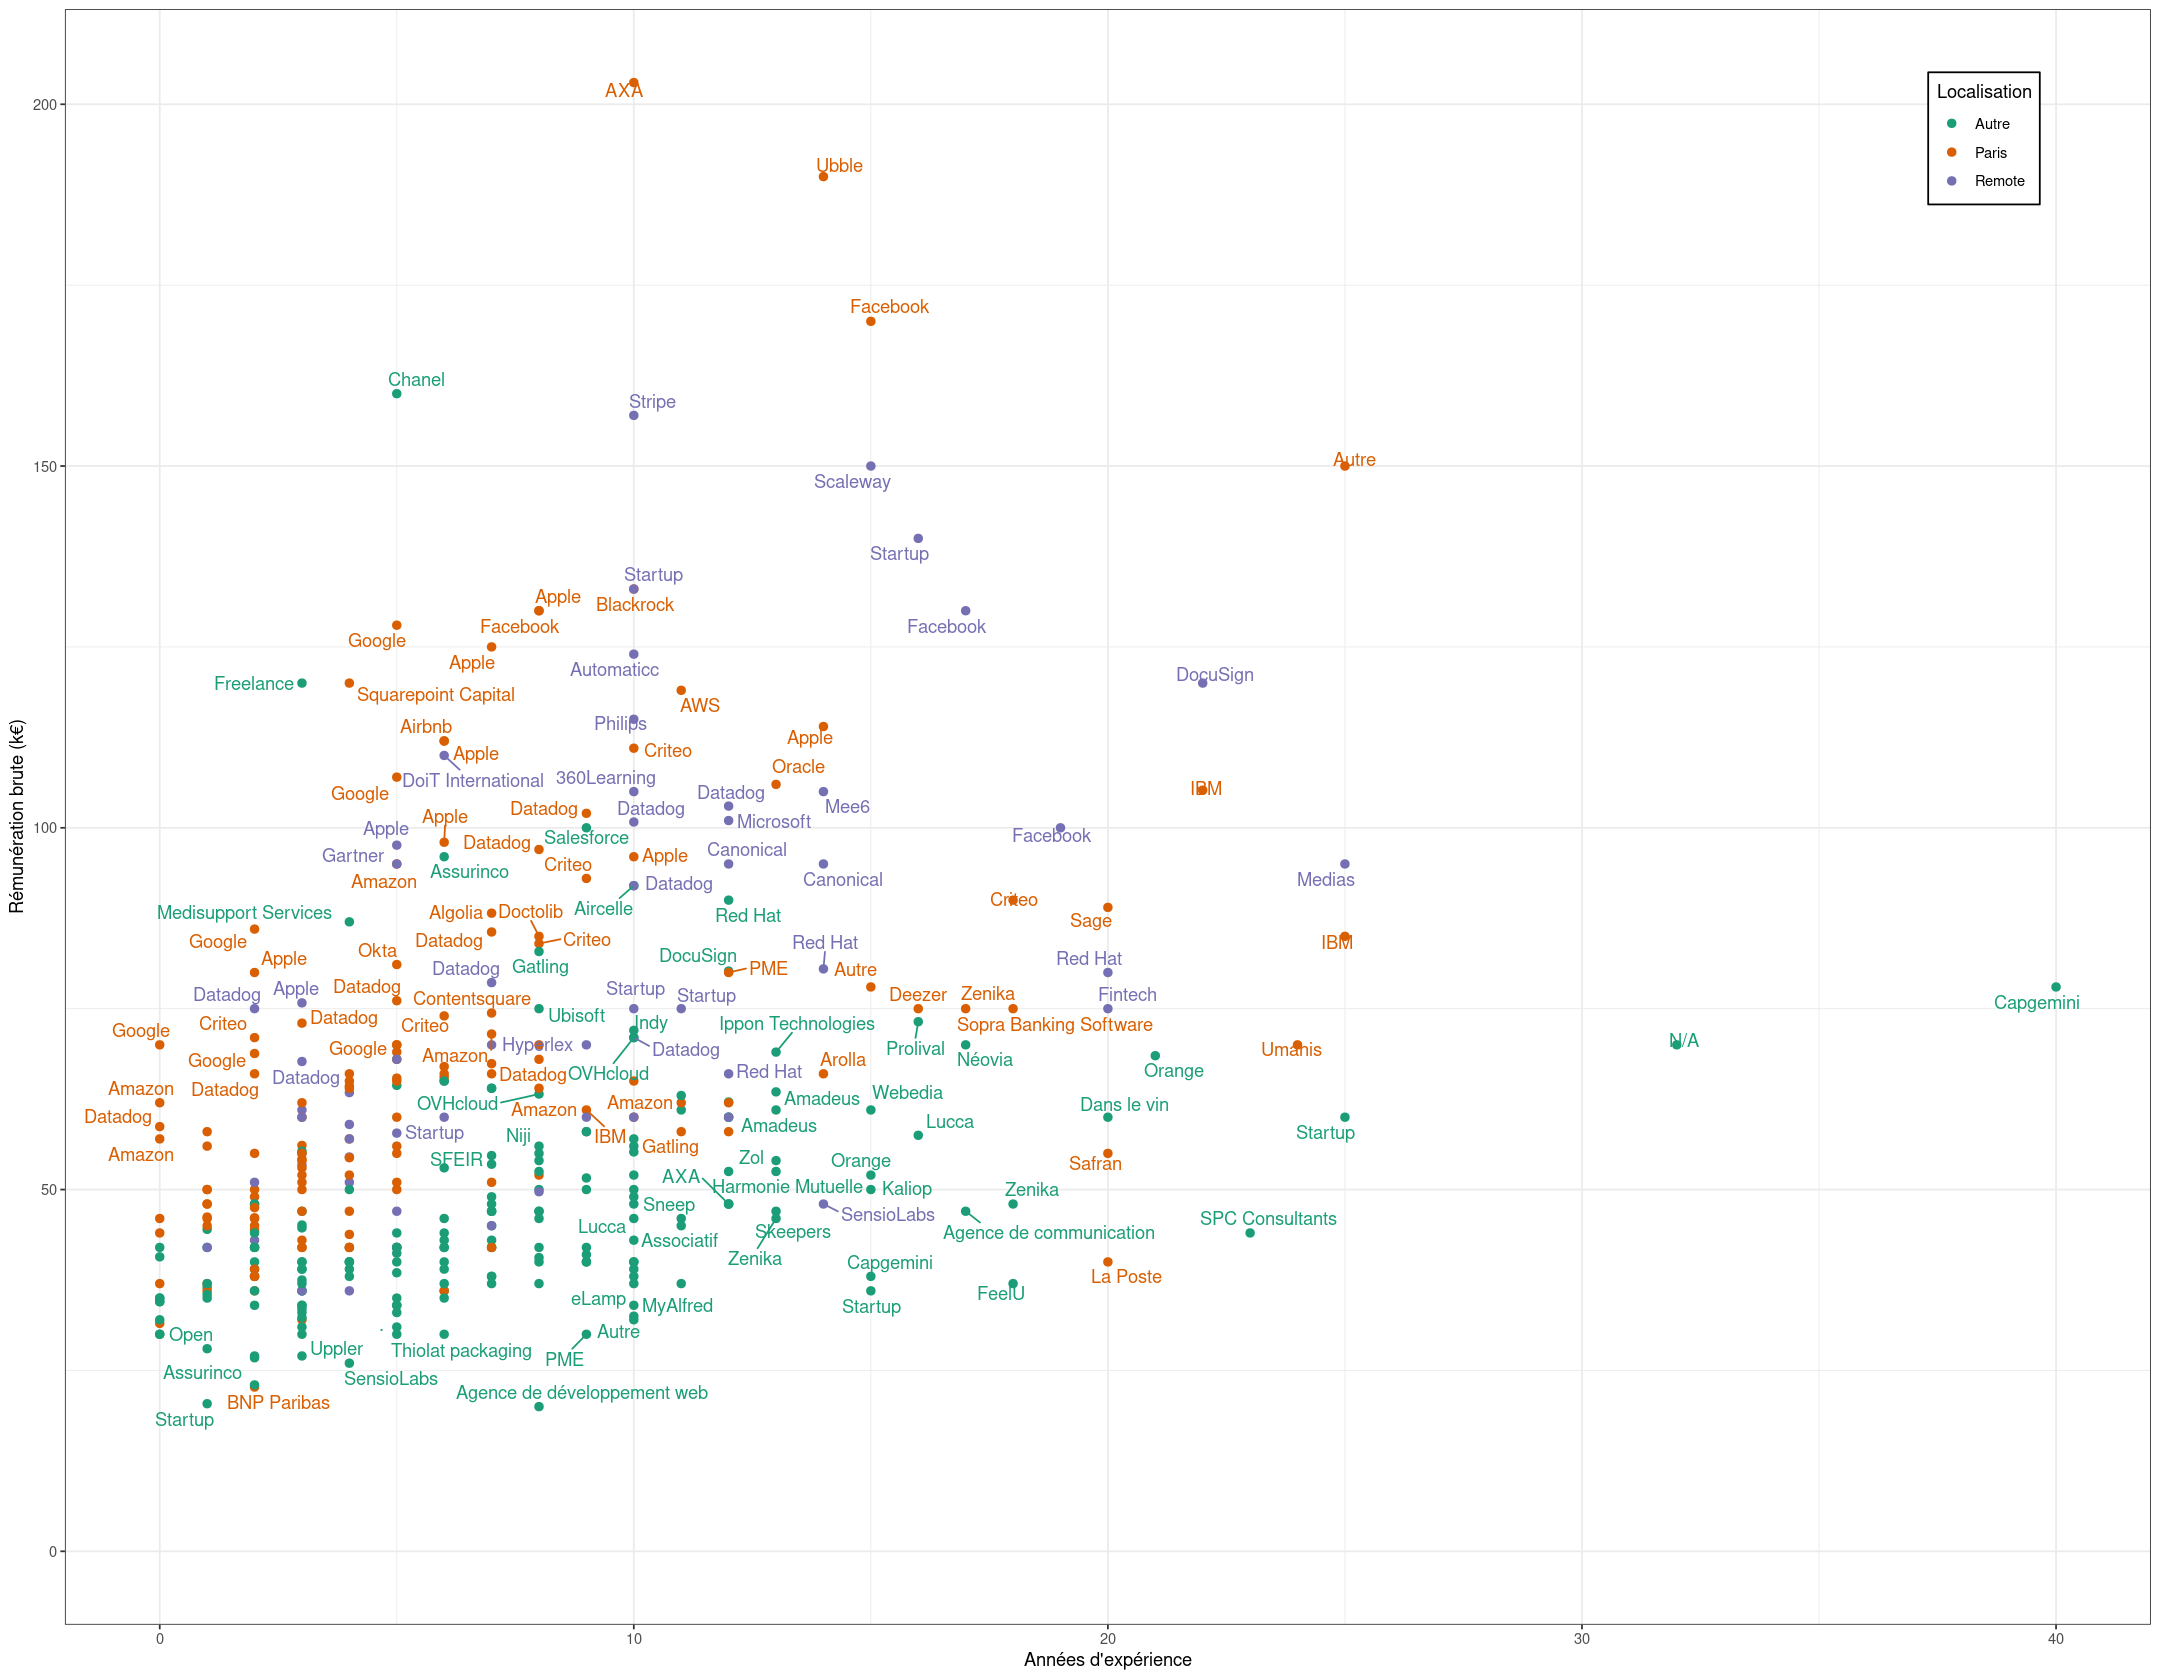

In [12]:
plot = df %>% ggplot() +
    aes(x=total_xp, y=compensation/1000, color=loc_short) +
    geom_point(size=2) +
    geom_text_repel (aes(label=comp_short), show.legend=F) +
    theme_bw() +
    scale_color_brewer(palette = "Dark2") +
    expand_limits(y=0) +
    labs(x="Années d'expérience", y="Rémunération brute (k€)", color="Localisation") +
    theme(legend.position=c(0.92, 0.92), legend.background = element_rect(colour = "black"))

plot

## Visualisations finales

Les deux courbes générées et partagées en ligne.

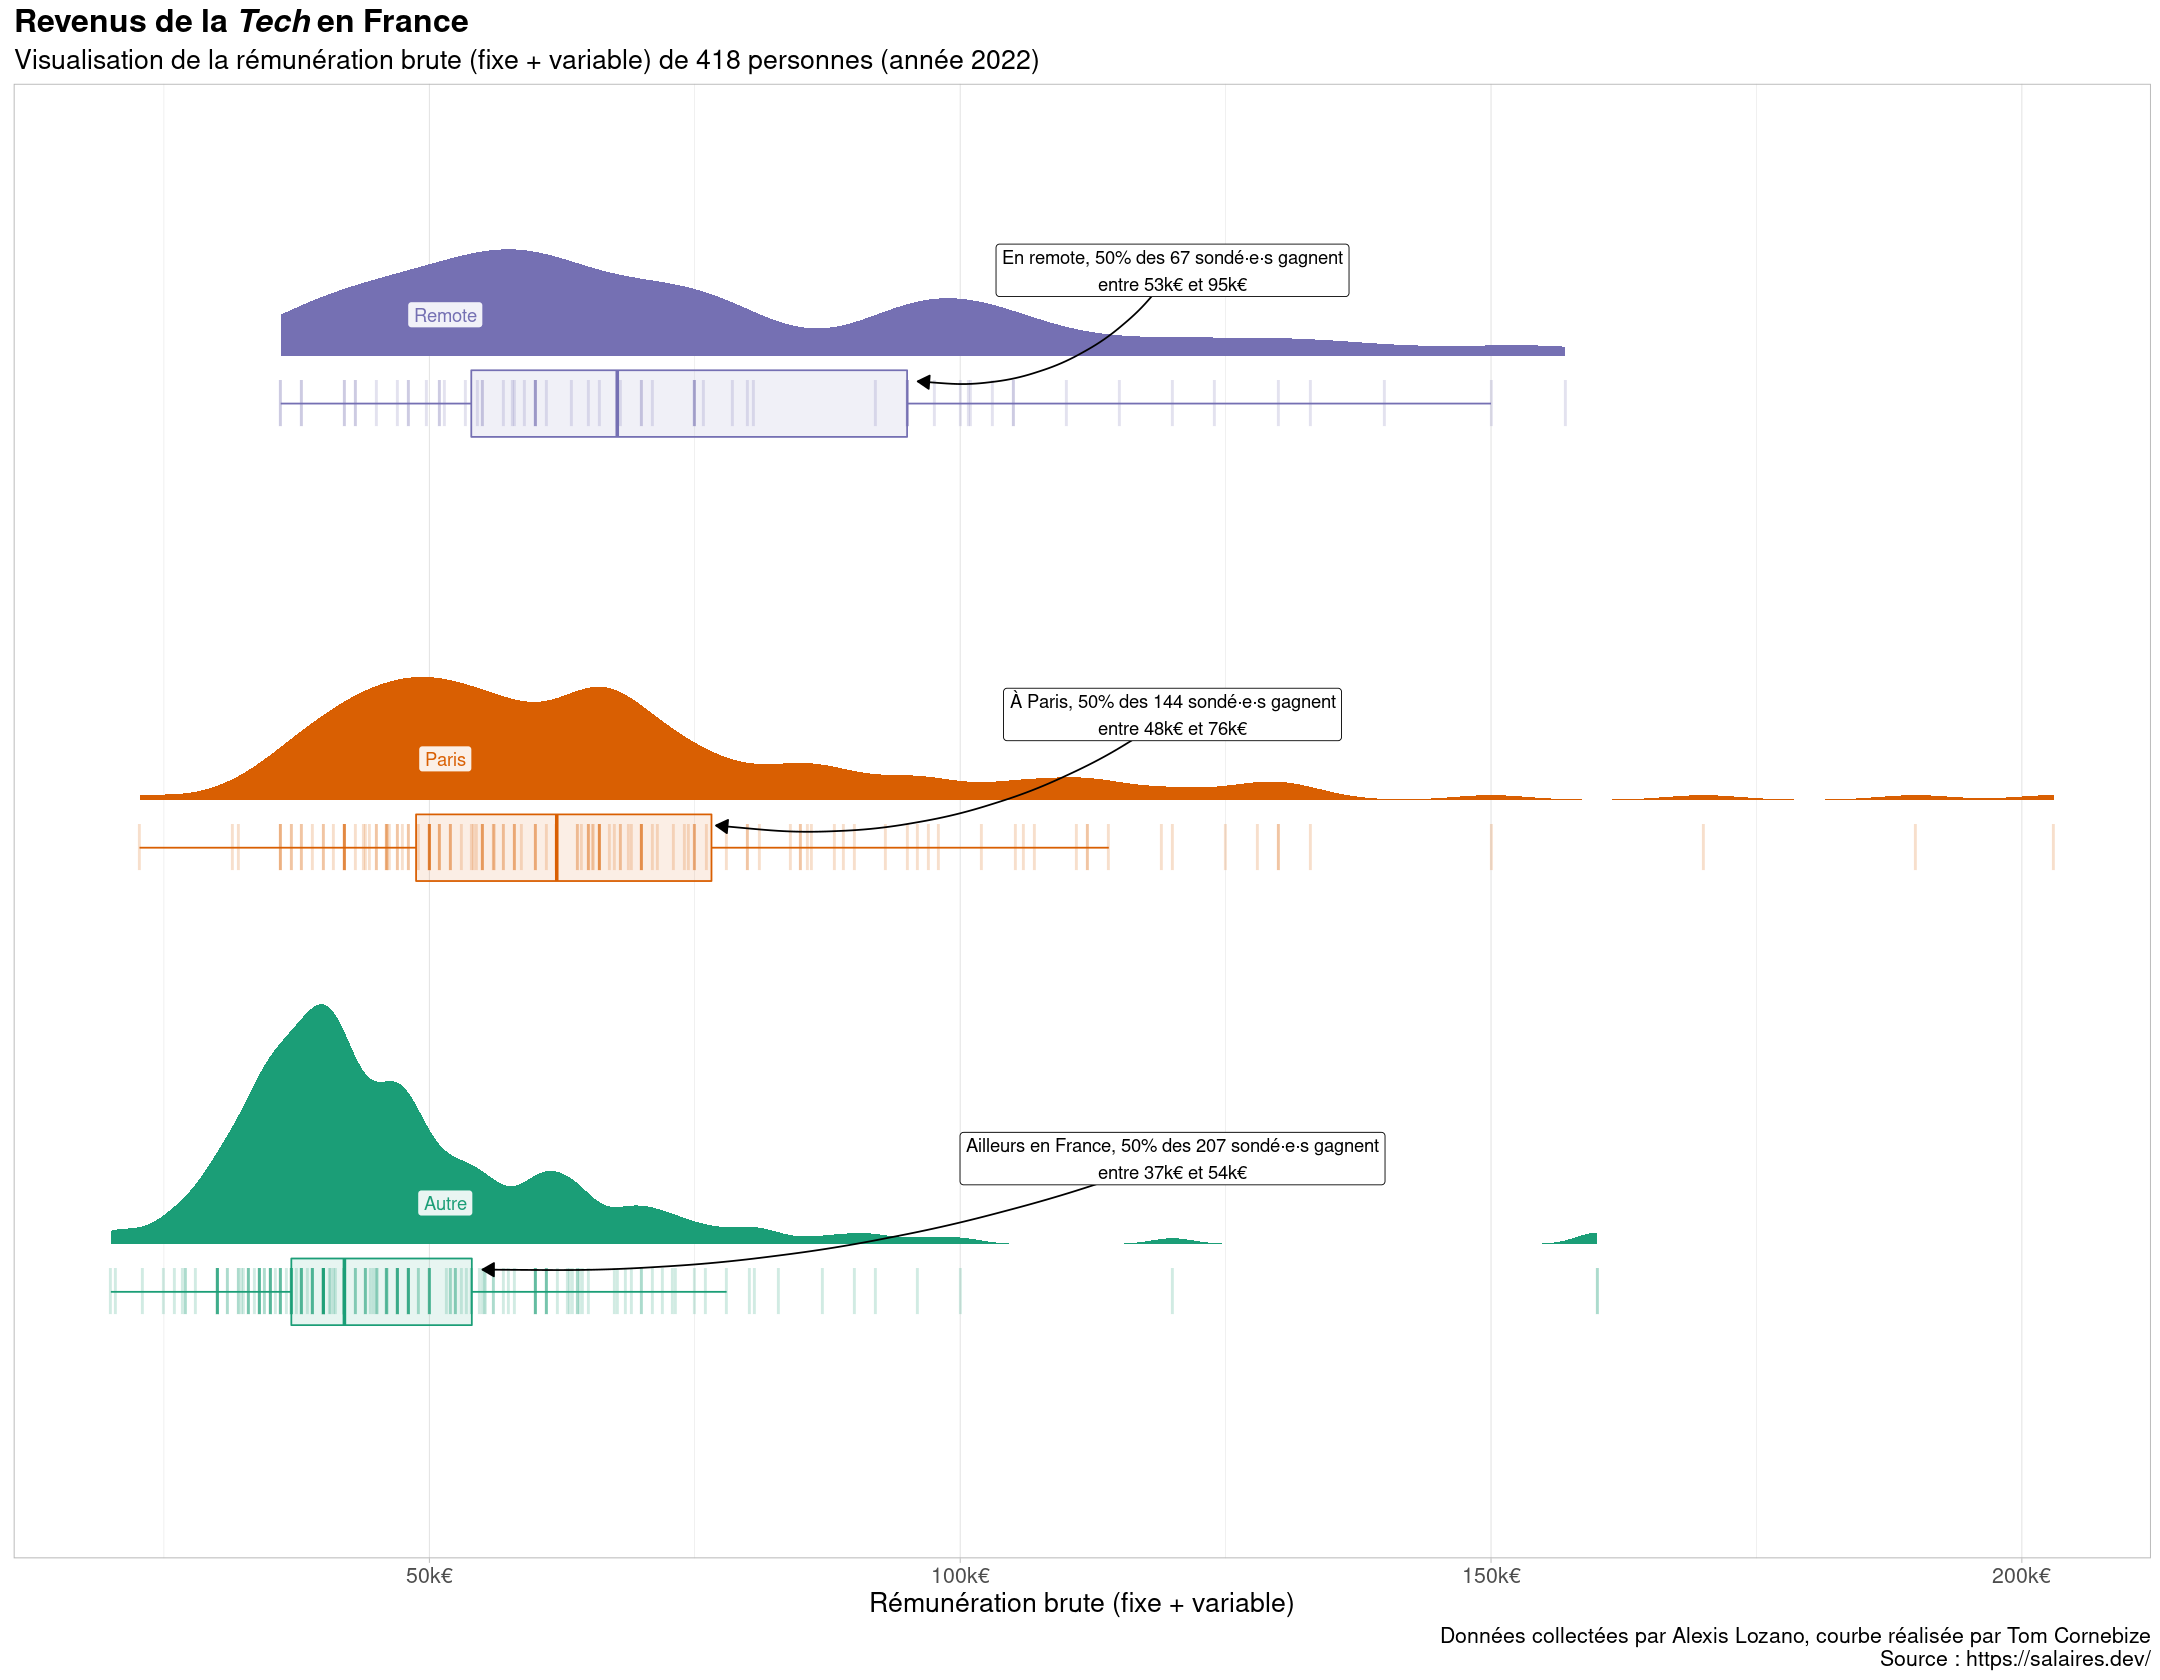

In [13]:
labs = df %>%
    select(loc_short) %>%
    unique() %>%
    mutate(compensation = df %>% pull(compensation) %>% median())

nb_entries = df %>%
    select(compensation) %>%
    count() %>%
    pull()

q_loc = function(loc, q) {
    res = df %>%
    filter(loc_short == loc) %>%
    pull(compensation) %>%
    quantile(q, names=F, type=3) / 1000
    round(res)
}

nb_loc = function(loc) {
    df %>%
        filter(loc_short == loc) %>%
        select(compensation) %>%
        count() %>%
        pull()
}

plot = df %>% ggplot() +
        aes(x=loc_short, y=compensation/1000, color=loc_short, fill=loc_short) +
        geom_point(
            ## draw horizontal lines instead of points
            shape = 124,
            size = 10,
            alpha = .2
        ) +
        geom_boxplot(
            width = .15, 
            outlier.shape = NA,
            alpha=0.1
        ) +
        ggdist::stat_halfeye(
            adjust = .5, 
            width = .6, 
            .width = 0, 
            justification = -.2, 
            point_colour = NA
        ) +
        geom_label(aes(label=loc_short), fill="white", alpha=0.9, data=labs, nudge_x =.2) +
        expand_limits(y=20) +
        theme_light() +
        theme(
            axis.text.y = element_blank(),
            axis.title.y = element_blank(),
            axis.ticks.y = element_blank(),
            panel.grid.major.y = element_blank(),
            legend.position = "none",
            text = element_text(size=16),
            plot.title = ggtext::element_markdown(),
        ) +
        annotate(
            geom = "curve",
            x = 3.3, xend = 3.05,
            y = 120, yend = q_loc("Remote", 0.75)+1,
            curvature = -.3,
            arrow = arrow(
                length = unit(8, "pt"),
                type = "closed"
            )
        ) +
        annotate(
            geom = "curve",
            x = 2.3, xend = 2.05,
            y = 120, yend = q_loc("Paris", 0.75)+1,
            curvature = -.2,
            arrow = arrow(
                length = unit(8, "pt"),
                type = "closed"
            )
        ) +
        annotate(
            geom = "curve",
            x = 1.3, xend = 1.05,
            y = 120, yend = q_loc("Autre", 0.75)+1,
            curvature = -.1,
            arrow = arrow(
                length = unit(8, "pt"),
                type = "closed"
            )
        ) +
        annotate("label", x=3.3, y=120, label=paste("En remote, 50% des ", nb_loc("Remote"), " sondé·e·s gagnent\nentre ", q_loc("Remote", 0.25), "k€ et ", q_loc("Remote", 0.75), "k€", sep="")) +
        annotate("label", x=2.3, y=120, label=paste("À Paris, 50% des ", nb_loc("Paris"), " sondé·e·s gagnent\nentre ", q_loc("Paris", 0.25), "k€ et ", q_loc("Paris", 0.75), "k€", sep="")) +
        annotate("label", x=1.3, y=120, label=paste("Ailleurs en France, 50% des ", nb_loc("Autre"), " sondé·e·s gagnent\nentre ", q_loc("Autre", 0.25), "k€ et ", q_loc("Autre", 0.75), "k€", sep="")) +
        coord_flip() +
        scale_color_brewer(palette = "Dark2") +
        scale_fill_brewer(palette = "Dark2") +
        scale_y_continuous(labels=scales::comma_format(suffix = "k€")) +
        labs(y="Rémunération brute (fixe + variable)") +
        ggtitle("**Revenus de la *Tech* en France**", subtitle=paste("Visualisation de la rémunération brute (fixe + variable) de ", nb_entries, " personnes (année 2022)", sep="")) +
        labs(caption="Données collectées par Alexis Lozano, courbe réalisée par Tom Cornebize\nSource : https://salaires.dev/")

ggsave("/home/tom/Downloads/salaires_1.png", plot, width=12, height=12)
plot

Warning message:
“Removed 29 rows containing non-finite values (stat_boxplot).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 29 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”
Warning message:
“Removed 29 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 297 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“Removed 29 rows containing non-finite values (stat_boxplot).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 29 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 29 rows containing missing values (geom_point).”
Warning message:
“Removed 29 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 367 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


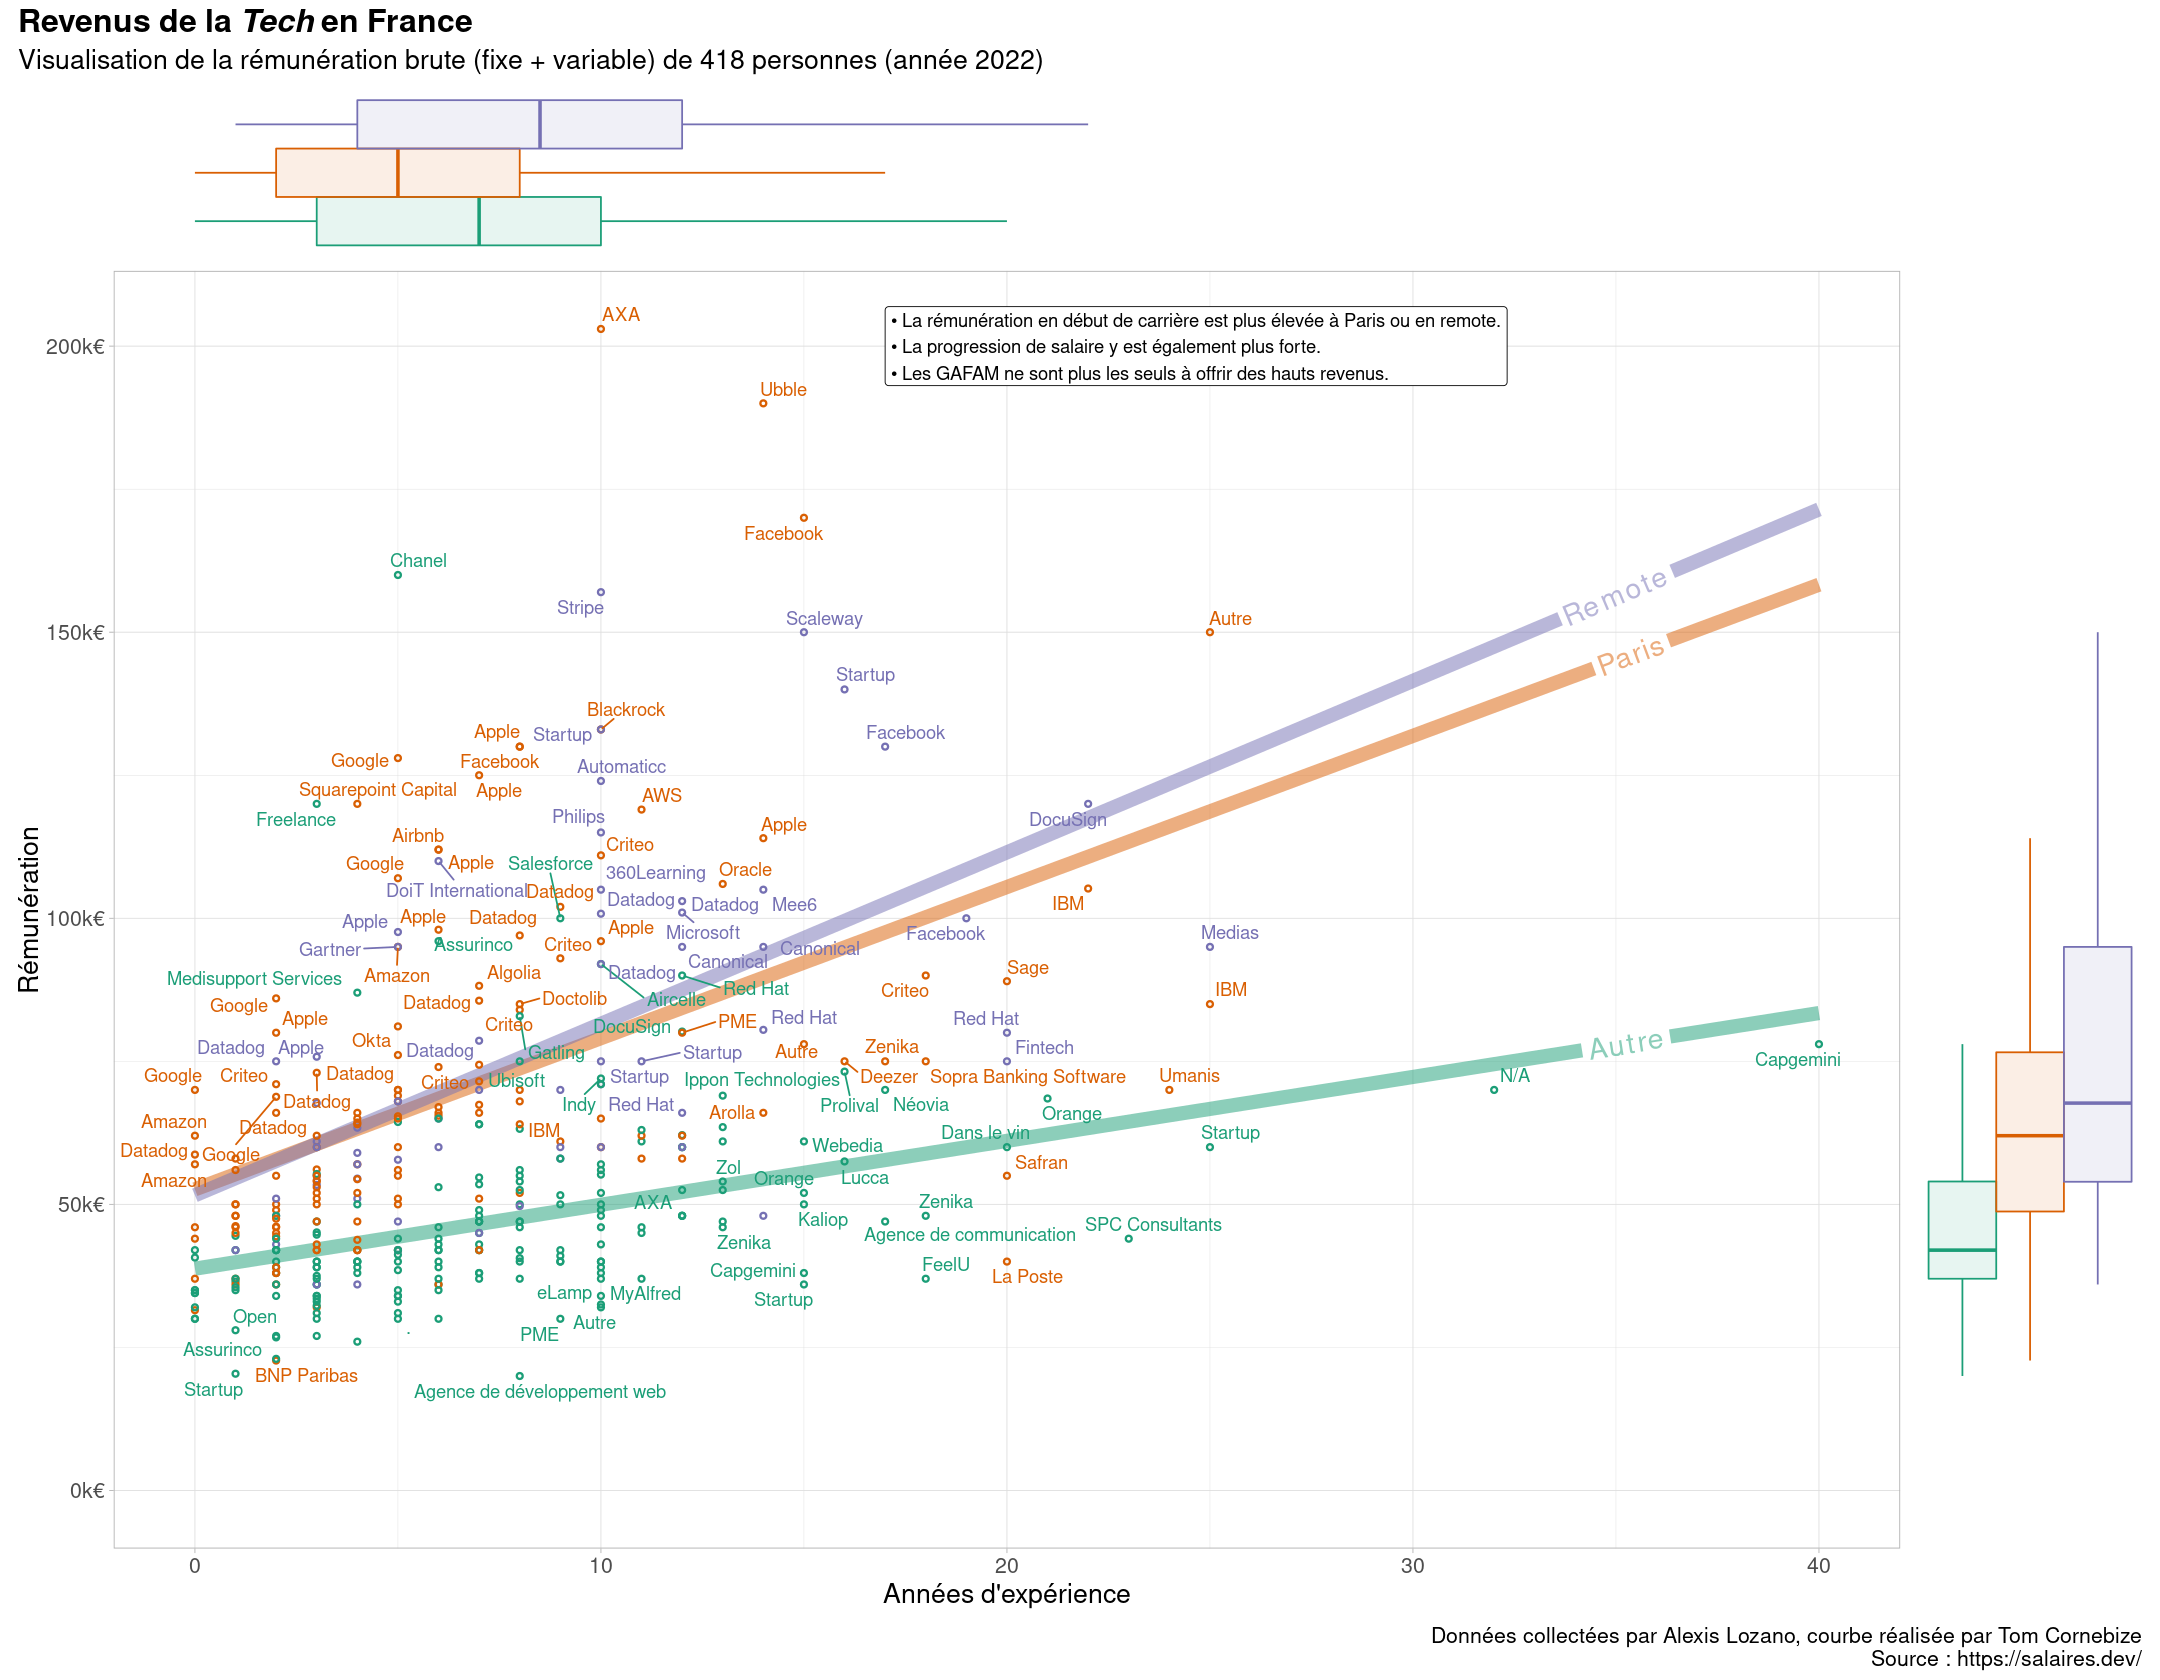

In [14]:
density_plot = df %>% ggplot() +
    aes(color=loc_short, fill=loc_short) +
    theme_void() +
    geom_boxplot(
            width = .05,
            outlier.shape = NA,
            alpha=0.1,
            position=position_dodge(0.05)
        )

plot_top = density_plot +
    aes(x=total_xp)
plot_right = density_plot +
    aes(x=compensation/1000) +
    coord_flip()

scatter_plot = df %>% ggplot() +
    aes(x=total_xp, y=compensation/1000, color=loc_short, group=loc_short) +
    geom_textsmooth (aes(label=loc_short), method="lm", se=F, fullrange=T, hjust=0.9, size=6, linewidth=4, alpha=0.5) +
    geom_point(shape=1, size=1, stroke=1) +
    theme_light() +
    theme(text = element_text(size=16)) +
    scale_y_continuous(labels=scales::comma_format(suffix = "k€")) +
    geom_text_repel (aes(label=comp_short), show.legend=F, max.overlaps=10) +
    labs(x="Années d'expérience", y="Rémunération") +
    annotate("label", x=17, y=200, label="• La rémunération en début de carrière est plus élevée à Paris ou en remote.\n• La progression de salaire y est également plus forte.\n• Les GAFAM ne sont plus les seuls à offrir des hauts revenus.", hjust=0)

plot =  plot_top + plot_spacer() + scatter_plot + plot_right +
        plot_layout(widths = c(8, 1), heights = c(1, 8)) &
        theme(legend.position='none') &
        scale_color_brewer(palette = "Dark2") &
        scale_fill_brewer(palette = "Dark2") &
        expand_limits(x=0, y=0) &
        plot_annotation(
            title = '**Revenus de la *Tech* en France**',
            subtitle = paste("Visualisation de la rémunération brute (fixe + variable) de ", nb_entries, " personnes (année 2022)", sep=""),
            caption = 'Données collectées par Alexis Lozano, courbe réalisée par Tom Cornebize\nSource : https://salaires.dev/',
            theme = theme(plot.title = ggtext::element_markdown(), text = element_text(size=16))
        )

ggsave("/home/tom/Downloads/salaires_2.png", plot, width=12, height=12)
plot